In [1]:
using Random, PyPlot, LinearAlgebra, Statistics, DataFrames, FITSIO, FITSTables, CSV, PyCall, JLD2

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/aw/.julia/packages/PyPlot/4wzW1/src/init.jl:192


In [6]:
include("get_lamost_spectra.jl")
LogNorm = pyimport("matplotlib.colors").LogNorm
include("../cats/human_readable_names.jl")
include("figures.jl")
include("model.jl")
include("air_vacuum.jl")
;

In [3]:
wl_grid = load("wl_grid.jld2")["wl_grid"];

In [4]:
Random.seed!(0)
ntest = 1000
test_obsids = rand(FITS(f->DataFrame(f[2]), "../cats/LAMOST-dr5-v3-stellar.fits.gz").obsid, ntest);
download_lamost_spectra(test_obsids);
test_spectra = []
test_ivar = []
for obsid in test_obsids
    wl, flux, ivar = load_lamost_spectrum(obsid, L=25)
    push!(test_spectra, flux)
    push!(test_ivar, ivar)
end

;

of 1000 spectra, 0 need to be downloaded


In [5]:
using JLD2, FileIO
@load "random_30000_rf_spectra.jld2"

2-element Array{Symbol,1}:
 :rf_spectra
 :rf_obsids 

In [277]:
wl_grid

3559-element Array{Union{Missing, Float64},1}:
 3900.31884765625 
 3901.217041015625
 3902.115478515625
 3903.013916015625
 3903.912841796875
 3904.811767578125
 3905.7109375     
 3906.610595703125
 3907.510009765625
 3908.409912109375
 3909.31005859375 
 3910.210205078125
 3911.11083984375 
    ⋮             
 8826.7353515625  
 8828.7685546875  
 8830.80078125    
 8832.8349609375  
 8834.869140625   
 8836.9033203125  
 8838.9384765625  
 8840.9736328125  
 8843.009765625   
 8845.0458984375  
 8847.0830078125  
 8849.1201171875  

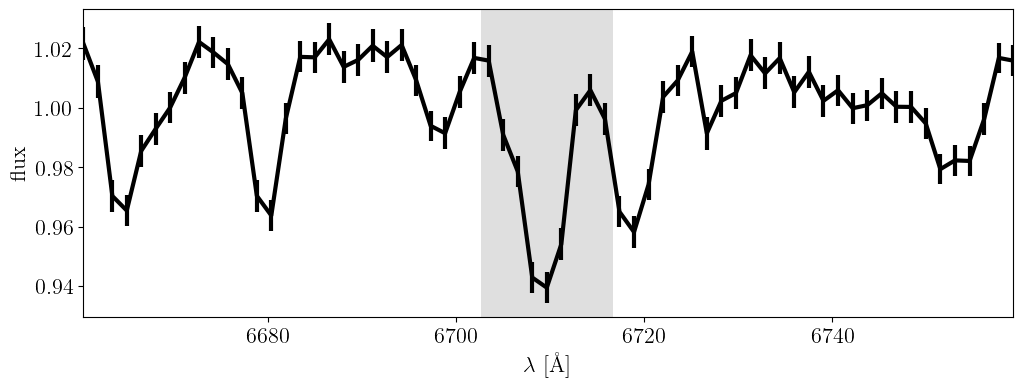

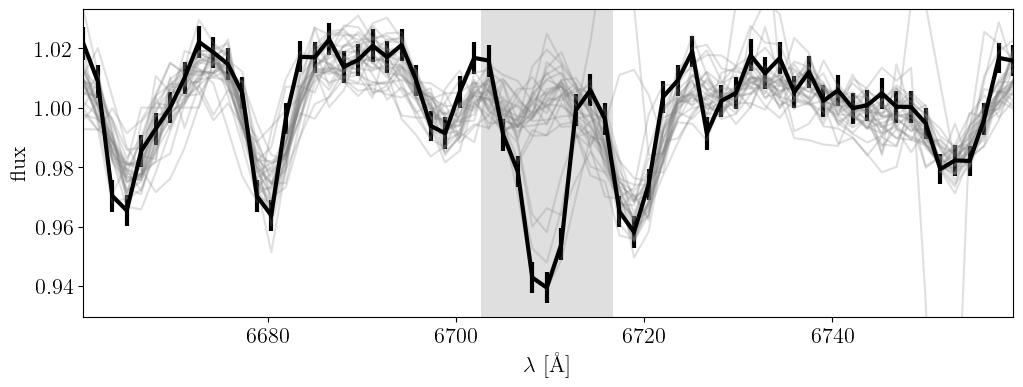

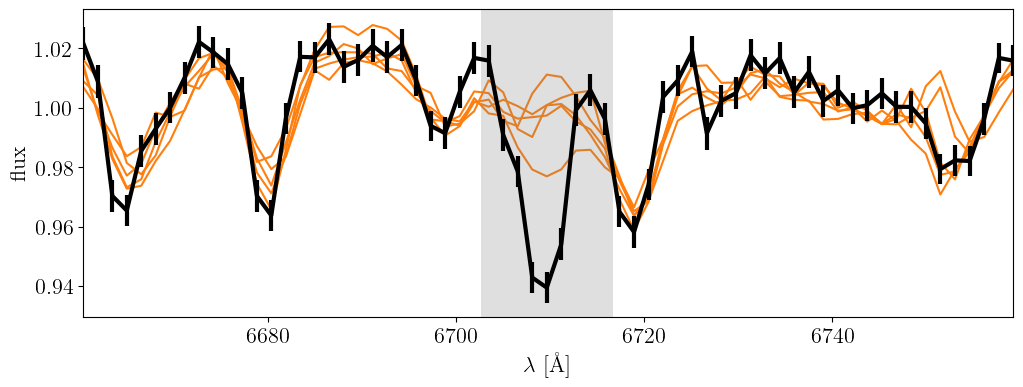

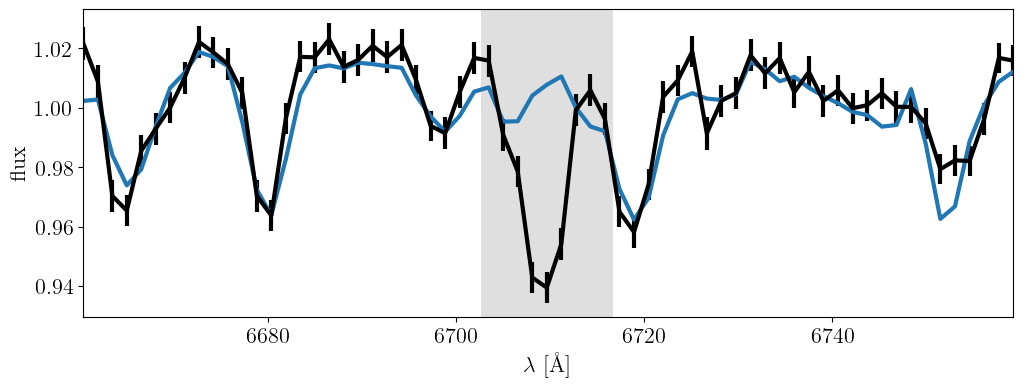

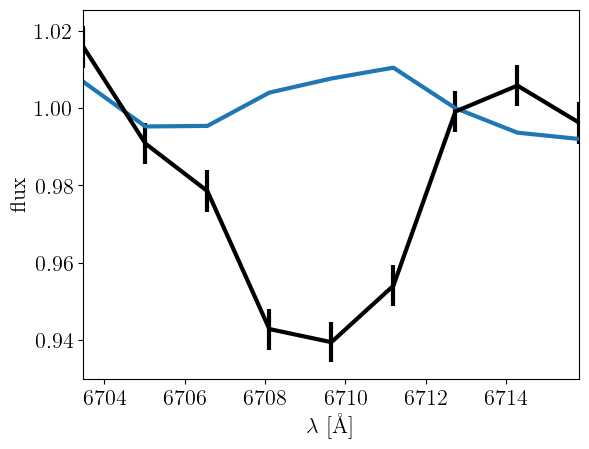

of 1 spectra, 0 need to be downloaded


In [297]:
maskfrac = 0.1
k = 30
q = 5
fontsize=16

#f, ivar = rand(collect(zip(test_spectra, test_ivar)))
#obsid = 37103095
obsid =  30015103
download_lamost_spectra([obsid])
_, f, ivar = load_lamost_spectrum(obsid, L=25)

Δλ = 7
li_line = air_to_vac(6707.85)
line_mask = li_line - Δλ .< wl_grid .< li_line + Δλ
plotmask = li_line - 50 .< wl_grid .< li_line + 50

figure(figsize=(12, 4))
errorbar(wl_grid[plotmask], f[plotmask], yerr=ivar[plotmask].^(-1/2), c="k", lw=3)
axvspan(li_line-Δλ, li_line+Δλ, fc="grey", alpha=0.25)
ylims = ylim()
xlabel(L"$\lambda$ [\AA]", fontsize=fontsize); ylabel("flux", fontsize=fontsize); 
gca().tick_params(labelsize=16)
xlim(wl_grid[plotmask][1], wl_grid[plotmask][end])

#-------------------------------------------------------------

F = rf_spectra[find_neighbors(f, rf_spectra, k), :]

figure(figsize=(12, 4))
errorbar(wl_grid[plotmask], f[plotmask], yerr=ivar[plotmask].^(-1/2), c="k", lw=3)
plot(wl_grid[plotmask], F[:, plotmask]', alpha=0.25, c="gray");
axvspan(li_line-Δλ, li_line+Δλ, fc="grey", alpha=0.25)
ylim(ylims)
xlabel(L"$\lambda$ [\AA]", fontsize=fontsize); ylabel("flux", fontsize=fontsize); 
xlim(wl_grid[plotmask][1], wl_grid[plotmask][end])
gca().tick_params(labelsize=16)

#-------------------------------------------------------------

μ = mean(F, dims=1)
F = (F .- μ)[1:end-1, :]
f = f - μ[:]

eivals, eivecs = eigen(F * F')
eispec = F' * eivecs[:, end-q+1:end]
eispec ./= sqrt.(sum(eispec.^2, dims=1))

figure(figsize=(12, 4))
plot(wl_grid[plotmask], (eispec'.+ μ)[:, plotmask]', c="C1", zorder=0)
errorbar(wl_grid[plotmask], (f + μ')[plotmask], yerr=ivar[plotmask].^(-1/2), c="k", lw=3);
axvspan(li_line-Δλ, li_line+Δλ, fc="grey", alpha=0.25)
xlabel(L"$\lambda$ [\AA]", fontsize=fontsize); ylabel("flux", fontsize=fontsize); 
xlim(wl_grid[plotmask][1], wl_grid[plotmask][end])
gca().tick_params(labelsize=16)

#-------------------------------------------------------------

invΣ = diagm(ivar[.! line_mask])
E = eispec[.! line_mask, :]
β = (E' * invΣ * E) \ (E' * invΣ * f[.! line_mask] )
pf = eispec * β + μ'
f = f + μ'

figure(figsize=(12, 4))
errorbar(wl_grid[plotmask], f[plotmask], yerr=ivar[plotmask].^(-1/2), c="k", lw=3)
plot(wl_grid[plotmask], pf[plotmask], lw=3)
axvspan(li_line-Δλ, li_line+Δλ, fc="grey", alpha=0.25)
xlabel(L"$\lambda$ [\AA]", fontsize=fontsize); ylabel("flux", fontsize=fontsize); 
xlim(wl_grid[plotmask][1], wl_grid[plotmask][end])
gca().tick_params(labelsize=16)

#-------------------------------------------------------------

figure()
errorbar(wl_grid[line_mask], f[line_mask], yerr=ivar[line_mask].^(-1/2), c="k", lw=3)
plot(wl_grid[line_mask], pf[line_mask], lw=3)
xlabel(L"$\labmda$ [\AA]", fontsize=fontsize); ylabel("flux", fontsize=fontsize); 
xlabel(L"$\lambda$ [\AA]"); ylabel("flux"); 
xlim(wl_grid[line_mask][1], wl_grid[line_mask][end])
gca().tick_params(labelsize=16)

#-------------------------------------------------------------

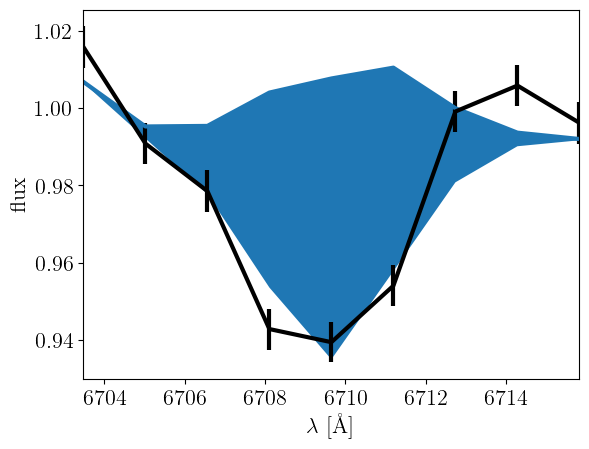

In [298]:
n = sum(line_mask)
M = zeros(2 + n, n)
ϕ(x, μ, σ) = exp(-1/2 * (x-μ)^2/σ^2) / sqrt(2π) / σ #gaussian kernel
#linemodel = ϕ.(wl_grid[line_mask], li_line, li_line/3600) 
M[1, :] = ϕ.(wl_grid[line_mask], li_line, li_line/3600) 
M[2, :] .= 1.0 
for i in 3:(2+n)
    M[i, i-2] = 1.
end 

invΣ = Diagonal(ivar[line_mask])
l1 = diag(M * invΣ * M')
l2 = M * invΣ * (f-pf)[line_mask]
loss = @. -l2^2 / l1

isline = argmin(loss) == 1
EEW = l2./l1
EEW_err = 1/sqrt(l1[1]) 

#errorbar(wl_grid[line_mask], f[line_mask], yerr=ivar[line_mask].^(-1/2), c="k", lw=3)
#plot(wl_grid[line_mask], pf[line_mask], lw=3)
#fill_between(wl_grid[line_mask], pf[line_mask], pf[line_mask] .+ M[2, :]*EEW[2], lw=3)
#xlabel(L"$\labmda$ [\AA]", fontsize=fontsize); ylabel("flux", fontsize=fontsize); 
#xlim(wl_grid[line_mask][1], wl_grid[line_mask][end])
#gca().tick_params(labelsize=16)
#
#figure()
#errorbar(wl_grid[line_mask], f[line_mask], yerr=ivar[line_mask].^(-1/2), c="k", lw=3)
#plot(wl_grid[line_mask], pf[line_mask], lw=3)
#fill_between(wl_grid[line_mask], pf[line_mask], pf[line_mask] .+ M[7, :]*EEW[7], lw=3)
#xlabel(L"$\labmda$ [\AA]", fontsize=fontsize); ylabel("flux", fontsize=fontsize); 
#xlabel(L"$\lambda$ [\AA]"); ylabel("flux"); 
#xlim(wl_grid[line_mask][1], wl_grid[line_mask][end])
#gca().tick_params(labelsize=16)

figure()
errorbar(wl_grid[line_mask], f[line_mask], yerr=ivar[line_mask].^(-1/2), c="k", lw=3)
plot(wl_grid[line_mask], pf[line_mask], lw=3)
fill_between(wl_grid[line_mask], pf[line_mask], pf[line_mask] .+ M[1, :]*EEW[1], lw=3)
xlabel(L"$\labmda$ [\AA]", fontsize=fontsize); ylabel("flux", fontsize=fontsize); 
xlabel(L"$\lambda$ [\AA]"); ylabel("flux"); 
xlim(wl_grid[line_mask][1], wl_grid[line_mask][end])
gca().tick_params(labelsize=16)